In [ ]:
import pickle, numpy as np

with open('tsnh/Mc.pickle-icl-adj.pickle', 'rb') as file:
    data = pickle.load(file)
    

In [1]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pickle, os

import torch, pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
import seaborn as sns
sns.set()

def softmax(x, temperature=1):
    return torch.exp(x/temperature) / torch.sum(torch.exp(x/temperature))

model_name = "LeoLM/leo-hessianai-7b-chat"

tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(model_name)

df = pd.read_excel("Adjektivliste-alphabetisch_Final.xlsx")
df['Hate Speech'] = df['Hate Speech'].fillna('').map(lambda x: x.upper())
df = df.sort_values(by=['Hate Speech'], ascending=False)
special_tokens = df['Adjektive '].tolist() + ['deutschsprachig']

special_tokens_encoding = tokenizer(special_tokens, add_special_tokens=False)['input_ids']
special_tokens, special_tokens_encoding = map(list,zip(*sorted(zip(special_tokens, special_tokens_encoding), key=lambda x: len(x[1]), reverse=True)))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
sum(i != '' for i in df['Hate Speech'].to_list())

169

In [ ]:
def get_probabilities(sentence, model, tokenizer):
    lt = "\n".join(special_tokens)
    template = f'Mit die Adjektiv liste{lt}\n\nDie folgende Äußerung: "{sentence}", kann am präzisesten mit dem Adjektiv beschrieben werden: \n'
    ids = tokenizer.encode(template, return_tensors="pt")
    batch_size = 24

    probabilities = torch.tensor([0.0]*len(special_tokens_encoding))

    with torch.no_grad():

        with tqdm(total=sum([len(i) for i in special_tokens_encoding])) as pbar:

            larger_index = len(special_tokens_encoding)
            step = 1
            while larger_index:
                for token_index in range(0, larger_index, batch_size):
                    
                    new_ids = []
                    for i in range(batch_size):
                        if token_index+i >= larger_index: 
                            break
                        if len(special_tokens_encoding[token_index+i]) < step: 
                            larger_index = token_index+i
                            break
                        new_ids += [special_tokens_encoding[token_index+i][:step]]
                    
                    if not len(new_ids):
                        break

                    batch = ids.repeat(len(new_ids), 1)
                    batch = torch.cat((batch, torch.tensor(new_ids)), dim=1)
                    
                    logits = model(batch).logits[...,-1,:].softmax(dim=-1)
                    interest_logits = logits[range(logits.size(0)), 
                                                    [new_ids[i][-1] for i in range(len(new_ids))]]
                    
                    assert all(logits[i][new_ids[i][-1]] ==  interest_logits[i] for i in range(len(new_ids)))
                    probabilities[token_index:token_index+len(new_ids)] += torch.log10(interest_logits)
                    pbar.update(len(new_ids))       
                step += 1
    return probabilities

In [2]:
parafrasis = ["Es ist ekelhaft, dass diese Ausländer hierher kommen, mit den Füßen aufstampfen und sich über gute irische Familien hinwegsetzen, um zu bekommen, was sie wollen.",
              "Es ist ekelhaft, dass diese Ausländer hierher kommen und auf guten irischen Familien herumtrampeln, um zu bekommen, was sie wollen.",
              "Es ist bedauerlich, dass diese Menschen aus dem Ausland hierherkommen und die Lebensweise guter irischer Familien beeinträchtigen, um ihre eigenen Ziele zu erreichen.",
              "Es ist bedauerlich, dass diese Personen aus anderen Ländern hierher kommen und die Lebensgrundlage respektabler irischer Familien beeinträchtigen, um ihre eigenen Interessen zu verfolgen."]


# special_tokens = df[df['Hate Speech'] == 'X']['Adjektive '].tolist() + ['Deutsch geschriebener Satz']

# probabilities_global = []
# for instance in parafrasis:
#     probabilities_global += [get_probabilities(instance, model, tokenizer)]
    

# with open('probabilities_global_1.pickle', 'wb') as handle:
#     pickle.dump(probabilities_global, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [5]:
with open('probabilities_global.pickle', 'rb') as handle:
    probabilities_global = pickle.load(handle)

In [6]:
normalized_log_prob = []
for i in range(4):
    normalized_log_prob += [torch.nn.functional.normalize(torch.tensor([value.item()/len(special_tokens_encoding[index]) for index, value in enumerate(probabilities_global[i])]),
                                                          p=2, dim=0)]

Es ist ekelhaft, dass diese Ausländer hierher kommen, mit den Füßen aufstampfen und sich über gute irische Familien hinwegsetzen, um zu bekommen, was sie wollen.
Es ist ekelhaft, dass diese Ausländer hierher kommen und auf guten irischen Familien herumtrampeln, um zu bekommen, was sie wollen.
Es ist bedauerlich, dass diese Menschen aus dem Ausland hierherkommen und die Lebensweise guter irischer Familien beeinträchtigen, um ihre eigenen Ziele zu erreichen.
Es ist bedauerlich, dass diese Personen aus anderen Ländern hierher kommen und die Lebensgrundlage respektabler irischer Familien beeinträchtigen, um ihre eigenen Interessen zu verfolgen.


Text(0, 0.5, 'log-probability')

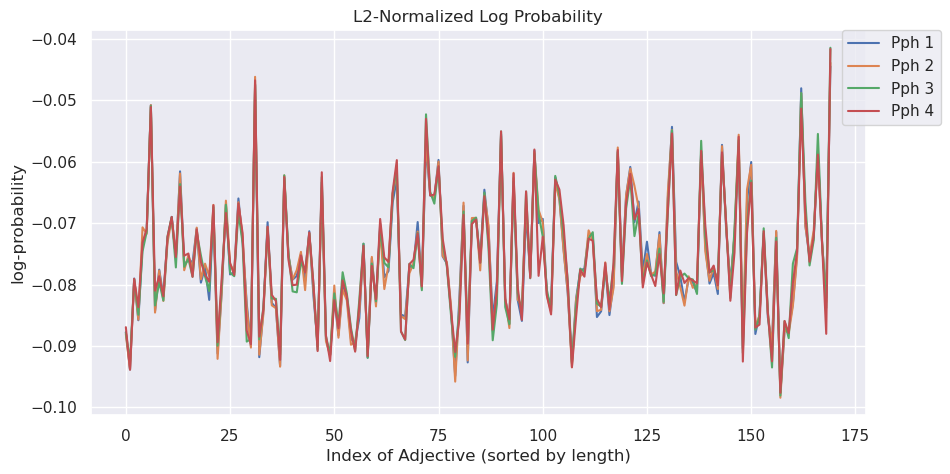

In [7]:
x = range(len(special_tokens))


import matplotlib.pyplot as plt
print('\n'.join(parafrasis))
plt.figure(figsize=(10,5))
for i in range(4):
    plt.plot(x, normalized_log_prob[i], label= f'Pph {i+1}')

plt.legend(bbox_to_anchor=(0.97, 1), loc='upper left', borderaxespad=0)
plt.title("L2-Normalized Log Probability")
plt.xlabel("Index of Adjective (sorted by length)")
plt.ylabel("log-probability")

In [7]:
#select 4-top-valued indices from the list of norm_log_prob[3]
top_ranked_adjectives = [special_tokens[i] for i in torch.argsort(normalized_log_prob[3], descending=True)[:10].tolist()]
low_ranked_adjectives = [special_tokens[i] for i in torch.argsort(normalized_log_prob[3], descending=False)[:10].tolist()]

pd.DataFrame(zip(top_ranked_adjectives, low_ranked_adjectives), columns=['Top Ranked', 'Low Ranked'])

,Top Ranked,Low Ranked
0,bitter,destruktiv
1,ettiketierend,verabscheuungswürdig
2,antifeministisch,unangenehm
3,inhuman,spöttisch
4,bodyshamend,vulgär
5,islamophob,schadenfroh
6,extremistisch,hasserfüllt
7,sexistisch,abfällig
8,rassistisch,erniedrigend
9,xenophob,unzufrieden


In [10]:

sentence = 'Ich bin sehr froh, dass es jetzt zu schneien beginnt.'
new_probabilites = get_probabilities(sentence, model, tokenizer)
new_probabilites_norm = torch.nn.functional.normalize(torch.tensor([value.item()/len(special_tokens_encoding[index]) for index, value in enumerate(new_probabilites)]),
                                                          p=2, dim=0)

100%|██████████| 697/697 [35:18<00:00,  3.04s/it]


Text(0, 0.5, 'log-probability')

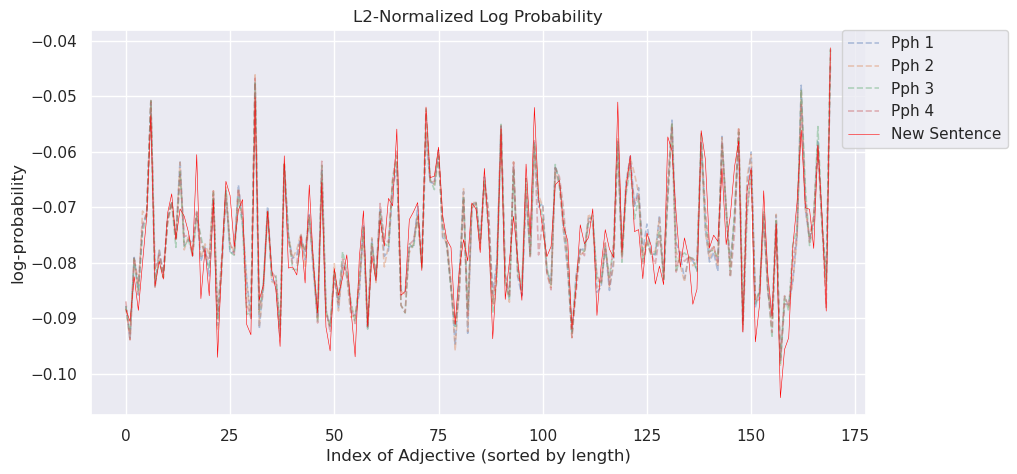

In [12]:
plt.figure(figsize=(10,5))
for i in range(4):
    plt.plot(x, normalized_log_prob[i], label= f'Pph {i+1}', alpha=0.4, linestyle='--', linewidth=1.2)

plt.plot(x, new_probabilites_norm, label = 'New Sentence', color='red', linewidth=0.4)

plt.legend(bbox_to_anchor=(0.97, 1), loc='upper left', borderaxespad=0)
plt.title("L2-Normalized Log Probability")
plt.xlabel("Index of Adjective (sorted by length)")
plt.ylabel("log-probability")

In [15]:
top_ranked_adjectives = [special_tokens[i] for i in torch.argsort(new_probabilites_norm, descending=True)[:10].tolist()]
low_ranked_adjectives = [special_tokens[i] for i in torch.argsort(new_probabilites_norm, descending=False)[:10].tolist()]

pd.DataFrame(zip(top_ranked_adjectives, low_ranked_adjectives), columns=['Top Ranked', 'Low Ranked'])

,Top Ranked,Low Ranked
0,bitter,destruktiv
1,xenophob,emotional
2,ettiketierend,unzufrieden
3,rassistisch,ausdrucksstark
4,bodyshamend,hasserfüllt
5,antifeministisch,schadenfroh
6,sexistisch,empört
7,islamophob,herausfordernd
8,inhuman,umstritten
9,lustig,erniedrigend


In [ ]:
""" 
    Complexity for each instance given by the complexity of generate the amount of adjetives.
    Consider using embedding similarity to find the most similar adjetives.

    Expand semantic consideration for each word.
    - consider sinonyms
    - consider hyponyms
    - agregate the values of the sinonyms and hyponyms to construct the representation or put them all in the representation.
"""

### Employing simpler version using conversacional model and predicting probabilities of a single adjective describe a sentence


In [2]:
# instances = ["Es ist ekelhaft, dass diese Ausländer hierher kommen, mit den Füßen aufstampfen und sich über gute irische Familien hinwegsetzen, um zu bekommen, was sie wollen.",
#               "Es ist ekelhaft, dass diese Ausländer hierher kommen und auf guten irischen Familien herumtrampeln, um zu bekommen, was sie wollen.",
#               "Es ist bedauerlich, dass diese Menschen aus dem Ausland hierherkommen und die Lebensweise guter irischer Familien beeinträchtigen, um ihre eigenen Ziele zu erreichen.",
#               "Es ist bedauerlich, dass diese Personen aus anderen Ländern hierher kommen und die Lebensgrundlage respektabler irischer Familien beeinträchtigen, um ihre eigenen Interessen zu verfolgen."]

instances = ["Es ist ekelhaft, dass diese Ausländer hierher kommen, mit den Füßen aufstampfen und sich über gute irische Familien hinwegsetzen, um zu bekommen, was sie wollen.",
              "@Wjanka634 @FeePatzer Und Deine sind extrem doof.",
              "Diese asiatische Horde und ihre Ostküsstenhelfer muss endlich in die Schranken gewiesen werden!",
              "Die Zersetzung,die Vernichtung der Kultur,der Abschaum,hat immer nur einen Ursprung!"] + \
              ['Ich bin sehr froh, dass es jetzt zu schneien beginnt.', 
               'Ich tue gerne Gutes für andere', 
               'Ich bin froh, heute zur Arbeit zu gehen.']


# SYSTEM_PERSONA = """<|im_start|>system
# Es handelt sich um ein Gespräch zwischen einem Studierenden und einem Experten für Linguistik und Sozialpsychologie mit langjähriger Erfahrung, \
# dessen Fähigkeit darin besteht, Verhaltens- und Persönlichkeitskonzepte zu vereinfachen und so zu vermitteln, dass sie auch für Laien leicht \
# verständlich sind.<|im_end|>
# """

SYSTEM_PERSONA = """<|im_start|>system
Sie sind eine Expertin für Sozialpsychologie mit langjähriger Erfahrung, deren Fähigkeit darin besteht,\
Verhaltens- und Persönlichkeitskonzepte zu vereinfachen und für Nicht-Experten leicht verständlich zu vermitteln.\
In der Tat geben Sie gerne konkrete und pragmatische Antworten.<|im_end|>
"""


# PROMPT = 'Überlegen Sie genau und sagen Sie mir, ob das Adjektiv "{word}" den folgenden Satz beschreibt: "{sentence}"'
PROMPT = 'Überlege genau und sage mir, ob das Adjektiv "{word}" den folgenden Satz in irgendeiner Weise beschreibt: "{sentence}"'

prompt_format = f"{SYSTEM_PERSONA}<|im_start|>user\n{PROMPT}<|im_end|>\n<|im_start|>assistant\n"

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return {key: value[0].to(DEVICE) for key, value in sample[0].items()}

def get_probabilities(prompt_format, sentence, model, tokenizer, batch_size):

    sorted_instances = [tokenizer(prompt_format.format(word=x, sentence=sentence), return_tensors='pt') for x in special_tokens]
    sorted_instances = sorted([(x, x['input_ids'].shape[-1], idx) for idx, x in enumerate(sorted_instances)], key = lambda x: x[1])

    batchable_sizes = [0] + [x[1] for x in sorted(Counter([x[1] for x in sorted_instances]).items())]
    batchable_sizes = [sum(batchable_sizes[:i+1]) for i in range(len(batchable_sizes))] 

    probabilities = None

    with tqdm(total=len(sorted_instances)) as pbar:
        
        with torch.no_grad():
            for block in range(1, len(batchable_sizes)):

                dataloader = DataLoader(CustomDataset(sorted_instances[batchable_sizes[block-1]:batchable_sizes[block]]), batch_size=batch_size, shuffle=False)
                for batch in dataloader:

                    logits = model(**batch).logits[:, -1, :]
                    probs = torch.nn.functional.softmax(logits, dim=-1)
                    probs = torch.sum(probs[:, [29967, 12337, 14021, 1764]], dim=-1).detach() #possible ja tokens !take sum instead max (probs)
                    
                    #check if probs are correct
                    assert all( probs < 1.0)
                    probabilities = torch.cat([probabilities, probs]) if probabilities is not None else probs
                    pbar.update(probs.shape[0])

    values = sorted([(x.item(), y[-1]) for x, y in zip(probabilities, sorted_instances)], key = lambda x: x[1])
    return [x[0] for x in values]


distributions = []

if os.path.exists('probabilities_yesno.pickle'):
    with open('probabilities_yesno.pickle', 'rb') as handle:
        distributions = pickle.load(handle)
else:
    for sentence in parafrasis + ['Ich bin sehr froh, dass es jetzt zu schneien beginnt.']:
        probabilities = get_probabilities(prompt_format, sentence, model, tokenizer, BATCH_SIZE=1)
        distributions += [probabilities]


Es ist ekelhaft, dass diese Ausländer hierher kommen, mit den Füßen aufstampfen und sich über gute irische Familien hinwegsetzen, um zu bekommen, was sie wollen.
@Wjanka634 @FeePatzer Und Deine sind extrem doof.
Diese asiatische Horde und ihre Ostküsstenhelfer muss endlich in die Schranken gewiesen werden!
Die Zersetzung,die Vernichtung der Kultur,der Abschaum,hat immer nur einen Ursprung!


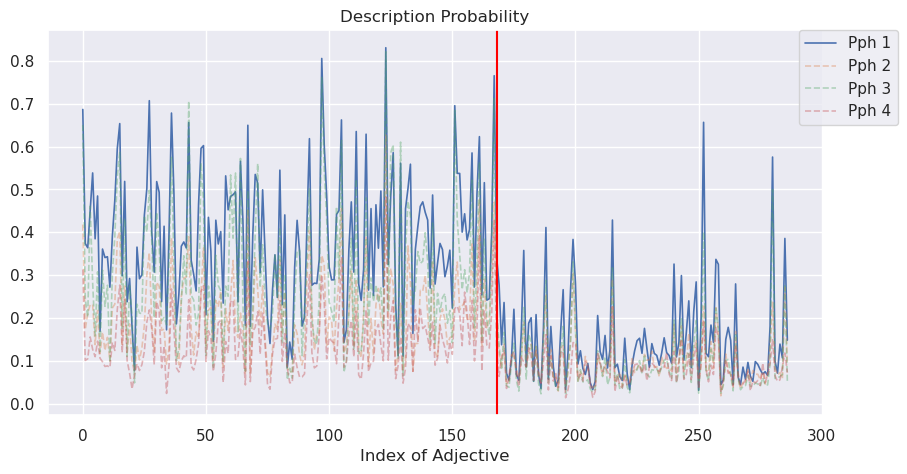

In [28]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
for i in range(4):
    plt.plot(range(len(distributions[1])), distributions[i], label= f'Pph {i+1}', alpha=0.4 if i else 1, linestyle='--'  if i else '-', linewidth=1.2)

# plt.plot(range(len(distributions[1])), distributions[4], label = 'New Sentence', color='red', linewidth=0.6)
#plot vertical line on position 168
plt.axvline(x=168, color='red', linestyle='-')
plt.legend(bbox_to_anchor=(0.97, 1), loc='upper left', borderaxespad=0)
plt.title("Description Probability")
plt.xlabel("Index of Adjective")

print('\n'.join(instances[:4]))

In [35]:
top_ranked_adjectives = [special_tokens[i] for i in torch.argsort(torch.tensor(distributions[0]), descending=True)[:10].tolist()]
low_ranked_adjectives = [special_tokens[i] for i in torch.argsort(torch.tensor(distributions[0]), descending=False)[:10].tolist()]

pd.DataFrame(zip(top_ranked_adjectives), columns=['Top Ranked'])

,Top Ranked
0,feindselig
1,terrorisierend
2,dialogfördernd
3,gewaltverurteilend
4,verärgert
5,grenzüberschreitend
6,gewalttätig
7,geringschätzend
8,optimistisch
9,schadenfroh


In [39]:
sorted(distributions[0])[-10:]

[0.6559879183769226,
 0.656482994556427,
 0.6620684862136841,
 0.6781868934631348,
 0.6865246295928955,
 0.6953897476196289,
 0.7070276737213135,
 0.7652299404144287,
 0.8054444193840027,
 0.8305050134658813]

In [ ]:
distributions[1]

## Check what are those outliers

In [11]:
top_ranked_adjectives = [special_tokens[i] for i in torch.argsort(torch.tensor(distributions[0]), descending=True).tolist() if i > 168][:10]

pd.DataFrame(zip(top_ranked_adjectives), columns=['Top Ranked Outliers'])

,Top Ranked Outliers
0,optimistisch
1,positiv
2,aggressiv
3,toxisch
4,fair
5,schamlos
6,nachfragend
7,friedlich
8,empathisch
9,geduldig


In [40]:
distributions[0][special_tokens.index('xenophob')]

0.4465298652648926

Ich bin sehr froh, dass es jetzt zu schneien beginnt.
Ich tue gerne Gutes für andere
Ich bin froh, heute zur Arbeit zu gehen.


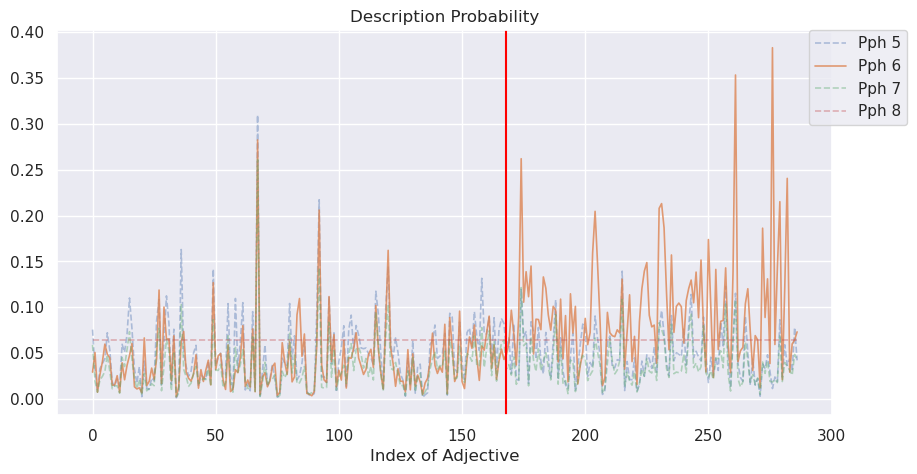

In [26]:
import numpy as np

plt.figure(figsize=(10,5))
distributions1 = distributions + [[np.mean(distributions[5])]*len(distributions[1])]
z = np.mean(distributions[1])
for i in range(4, 8):
    plt.plot(range(len(distributions[1])), distributions1[i], label= f'Pph {i+1}', alpha=0.4 if i != 5 else 0.8 , linewidth=1.2, linestyle='--' if i!=5 else '-')

# plt.plot(range(len(distributions[1])), distributions[4], label = 'New Sentence', color='red', linewidth=0.6)
#plot vertical line on position 168
plt.axvline(x=168, color='red', linestyle='-')
plt.legend(bbox_to_anchor=(0.97, 1), loc='upper left', borderaxespad=0)
plt.title("Description Probability")
plt.xlabel("Index of Adjective")

print('\n'.join(instances[4:]))

In [34]:
top_ranked_adjectives = [special_tokens[i] for i in torch.argsort(torch.tensor(distributions[5]), descending=True)[:10].tolist()]
low_ranked_adjectives = [special_tokens[i] for i in torch.argsort(torch.tensor(distributions[5]), descending=False)[:10].tolist()]

pd.DataFrame(zip(top_ranked_adjectives ,low_ranked_adjectives), columns=[ 'Top Ranked','Low Ranked'])
# sarcastic XD

,Top Ranked,Low Ranked
0,besonnen,herabwürdigend
1,grob,faktenbasiert
2,respektvoll,wertschätzend
3,achtungsvoll,verständnisvoll
4,gelassen,bösartig
5,mutig,kontrastierend
6,solidarisch,respektlos
7,vermittelnd,räsonnierend
8,zuwiderlaufend,ehrverletzend
9,relativierend,rücksichtslos


In [20]:
from pprint import pprint

pprint('Überlegen Sie genau und sagen Sie mir, ob das Adjektiv Deutsch geschriebener Satz den folgenden Satz beschreibt:"Ich bin sehr froh, dass es jetzt zu schneien beginnt."')
pprint('Nein, der Satz ist nicht mit dem Adjektiv beschrieben, da das Adjektiv "Deutsch" bedeutet, dass der Satz in deutscher Sprache verfasst wurde, nicht dass er einen Zustand des Glücks beschreibt.')

('Überlegen Sie genau und sagen Sie mir, ob das Adjektiv Deutsch geschriebener '
 'Satz den folgenden Satz beschreibt:"Ich bin sehr froh, dass es jetzt zu '
 'schneien beginnt."')
('Nein, der Satz ist nicht mit dem Adjektiv beschrieben, da das Adjektiv '
 '"Deutsch" bedeutet, dass der Satz in deutscher Sprache verfasst wurde, nicht '
 'dass er einen Zustand des Glücks beschreibt.')


In [30]:
print(tokenizer(['ja', ' Ja', ' ja', 'Ja', '\nJa', '\nja'], add_special_tokens=False)['input_ids'])
ja_tokens = [29967, 29967, 12337, 14021, 12337, 29967, 1764]

[[12337], [29871, 14021], [29871, 12337], [14021], [29871, 13, 29967, 29874], [29871, 13, 1764]]


## ~ (Hate Speech) ^ ~ (Counter Speech) ^ (Counter Hate)

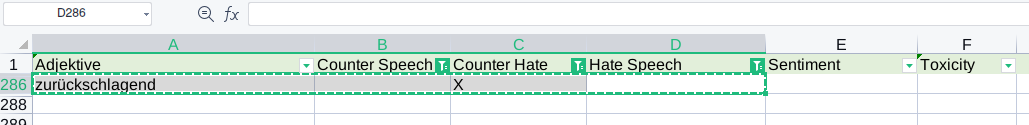



## ~ (Hate Speech) ^ (Counter Speech) ^ (Counter Hate)

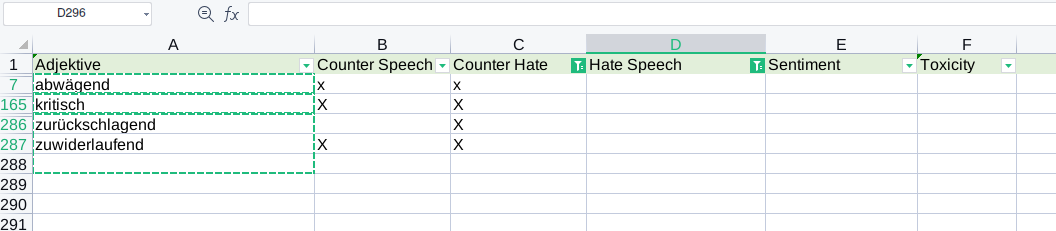

In [14]:
l = """ermutigend
gewaltfrei
friedfertig
friedlich
motivierend
optimistisch
positiv
wertschätzend"""

for z in l.split('\n'):
    print(f'{distributions[4][special_tokens.index(z)].item():.3f}', z)

0.330 ermutigend
0.047 gewaltfrei
0.140 friedfertig
0.293 friedlich
0.234 motivierend
0.132 optimistisch
0.184 positiv
0.005 wertschätzend


In [4]:
import numpy as np, pandas as pd
import pickle

with open('probabilities_yesno_hateval.pickle', 'rb') as handle:
    data_transformation = pickle.load(handle)
    mapping = {data_transformation['id'][i]:np.array(data_transformation['values'][i]) for i in range(len(data_transformation['id']))}
df = pd.read_csv('GermEval2018_200sample.tsv', sep='\t')

In [11]:
len(data_transformation['values'][0])

287

In [5]:
feature_vectors = []
labels = []
texts = []

for _, row in df.iterrows():
    feature_vectors += [mapping[row['Column1']]]
    labels += [row['hate']]
    texts += [row['text']]

feature_vectors = np.array(feature_vectors)


labels = np.array(labels)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, accuracy_score as acc

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
feature_vector_tfidf = vectorizer.fit_transform(texts).toarray()


from functools import partial


models = {
    'Logistic Regression': partial(LogisticRegression, random_state=42),
    'SVM': partial(SVC, kernel='linear', C=1, random_state=42),
    'Random Forest': partial(RandomForestClassifier),
    'Gradient Boosting': partial(GradientBoostingClassifier),
    'MLP': partial(MLPClassifier)
}

skf = StratifiedKFold(n_splits=5, shuffle=True)

def evaluate(model, X_test, y_test):

    y_pred = model.predict(X_test)
    return acc(y_test, y_pred,)


performance = {}
t_performance = {}

for train_index, test_index in skf.split(feature_vectors, labels):

    X_train, X_test = feature_vectors[train_index], feature_vectors[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    for model_name, model in models.items():
        if model_name not in performance: 
            performance[model_name] = []
            t_performance[model_name] = []

        clf = model()
        clf.fit(X_train, y_train)
        performance[model_name] += [evaluate(clf, X_test, y_test)]
        t_performance[model_name] += [evaluate(clf, X_train, y_train)]

    if 'tfidf' not in performance: 
        performance['tfidf'] = []
        t_performance['tfidf'] = []
    
    clf = models['SVM']()
    clf.fit(feature_vector_tfidf[train_index], labels[train_index])
    performance['tfidf'] += [evaluate(clf, feature_vector_tfidf[test_index], y_test)]
    t_performance['tfidf'] += [evaluate(clf, feature_vector_tfidf[train_index], y_train)]

/opt/anaconda/envs/labadier_hs/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda/envs/labadier_hs/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda/envs/labadier_hs/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda/envs/labadier_hs/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt

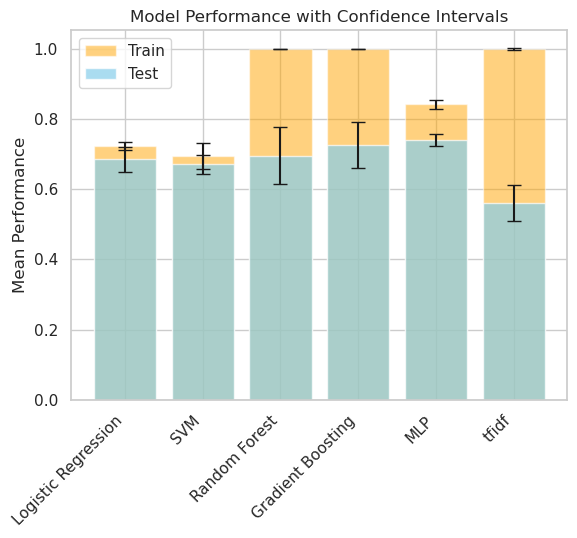

In [20]:
from scipy.stats import t
from matplotlib import pyplot as plt

sns.set_style("whitegrid")
def calculate_ci(data, confidence=0.95):
    n = len(data)
    m, se = np.mean(data), np.std(data, ddof=1) / np.sqrt(n)
    h = se * t.ppf((1 + confidence) / 2., n-1)
    return h,  h


fig, ax = plt.subplots()

models_list = list(models.keys()) + ['tfidf']
mean_values = [np.mean(performance[i]) for i in models_list]
ci_values = np.array([calculate_ci(performance[i]) for i in models_list]).T

t_mean_values = [np.mean(t_performance[i]) for i in models_list]
t_ci_values = np.array([calculate_ci(t_performance[i]) for i in models_list]).T

ax.bar(models_list, t_mean_values, yerr=t_ci_values, capsize=5, color='orange', alpha=0.5, label='Train')
ax.bar(models_list, mean_values, yerr=ci_values, capsize=5, color='skyblue', alpha=0.7, label='Test')

ax.set_ylabel('Mean Performance')
ax.legend(loc='upper left')
ax.set_title('Model Performance with Confidence Intervals')
plt.xticks(rotation=45, ha='right')

plt.show()


In [29]:
df

,id,Class,Context,Text,Input
0,0,2,The UK is fucked.,>The ~~UK~~ world is fucked FTFY,The UK is fucked. [SEP] >The ~~UK~~ world is f...
1,1,0,Listen to this wisdom.,Where the Fuck did you get that up arrow?,Listen to this wisdom. [SEP] Where the Fuck di...
2,2,1,"""That's different.""",You're right. The ultrasound says it's a girl....,"""That's different."" [SEP] You're right. The ul..."
3,3,2,"Oh fuck offffff, this is just patently untrue ...",Lol you can always spot a valid arguement when...,"Oh fuck offffff, this is just patently untrue ..."
4,4,2,This whole sub should come to terms with reali...,I stopped reading your history after you wante...,This whole sub should come to terms with reali...
...,...,...,...,...,...
3320,3320,2,So bitter. I'm a mr mum and it's not that fuck...,So enlighten us. How did your divorce compare ...,So bitter. I'm a mr mum and it's not that fuck...
3321,3321,0,I love how these people are all conveniently t...,Feminists only need to imagine it happened,I love how these people are all conveniently t...
3322,3322,0,"It's in the old testament, and jesus was circu...",That's an extremely disturbing cult you are re...,"It's in the old testament, and jesus was circu..."
3323,3323,2,I'm trying to explain it to you in a manner yo...,You're trying to say that after sex you can't ...,I'm trying to explain it to you in a manner yo...


In [1]:

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd, numpy as np

df_train = pd.read_csv('HS_CS_Context_Does_Matter/HS_CS_CDM_Task2_gold_train_uniform.csv')
df_test = pd.read_csv('HS_CS_Context_Does_Matter/HS_CS_CDM_Task2_gold_test_uniform.csv')


feature_vectors_train = []
labels_train = []
texts_train = []

feature_vectors_test = []
labels_test = []
texts_test = []


for _, row in df_train.iterrows():
    labels_train += [row['Class']]
    # texts_train += [ row['Text']]
    texts_train += [ row['Context'] + row['Text']]


for _, row in df_test.iterrows():
    labels_test += [row['Class']]
    # texts_test += [ row['Text']]
    texts_test += [row['Context'] + row['Text']]


vectorizer = TfidfVectorizer(ngram_range = (3, 3), analyzer='char').fit(texts_train)

data_train = {'x': vectorizer.transform(texts_train).toarray(), 'y': labels_train}
data_test = {'x': vectorizer.transform(texts_test).toarray(), 'y': labels_test}

In [ ]:


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, accuracy_score as acc

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

from functools import partial


models = {
    'Logistic Regression': partial(LogisticRegression),
    'SVM': partial(SVC, kernel='linear', C=1),
    'Random Forest': partial(RandomForestClassifier),
    'Gradient Boosting': partial(GradientBoostingClassifier),
    'MLP': partial(MLPClassifier)
}

def evaluate(model, X_test, y_test):

    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred,average='macro')

for i in range(5):
	performance = {}
	t_performance = {}
	for model_name, model in tqdm( models.items()):

		clf = model()
		if i < 2 or model_name in ['Logistic Regression', 'SVM']:
			continue

		clf.fit(data_train['x'], data_train['y'])
		performance[model_name] = evaluate(clf, data_test['x'], data_test['y'])
		# t_performance[model_name] = evaluate(clf, data_train['x'], data_train['y'])
		
		# clf = models['SVM']()
		# clf.fit(feature_vector_tfidf[train_index], labels[train_index])
		# performance['tfidf'] += [evaluate(clf, feature_vector_tfidf[test_index], y_test)]
		# t_performance['tfidf'] += [evaluate(clf, feature_vector_tfidf[train_index], y_train)]
	print(performance)


100%|██████████| 5/5 [00:00<00:00, 33078.11it/s]


{}


100%|██████████| 5/5 [00:00<00:00, 53635.60it/s]


{}


100%|██████████| 5/5 [13:00<00:00, 156.10s/it]


{'Random Forest': 0.314617592145682, 'Gradient Boosting': 0.38936121436284377, 'MLP': 0.3969700574100015}


100%|██████████| 5/5 [12:04<00:00, 144.82s/it]


{'Random Forest': 0.3206772125169035, 'Gradient Boosting': 0.36899835927464264, 'MLP': 0.39993180148987517}


 60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

In [1]:
import pandas as pd, numpy as np, seaborn as sns, pickle

with open('probabilities_germeval_test.csv.pickle', 'rb') as handle:    
    data = pickle.load(handle)
gold = pd.read_csv('germeval_test.csv')


In [2]:
data['values'] = [i[0] for i in data['values']]
data = pd.DataFrame(data)

In [3]:
data.rename(columns={'id': 'index'}, inplace=True)
z = gold.merge(data, on='index')

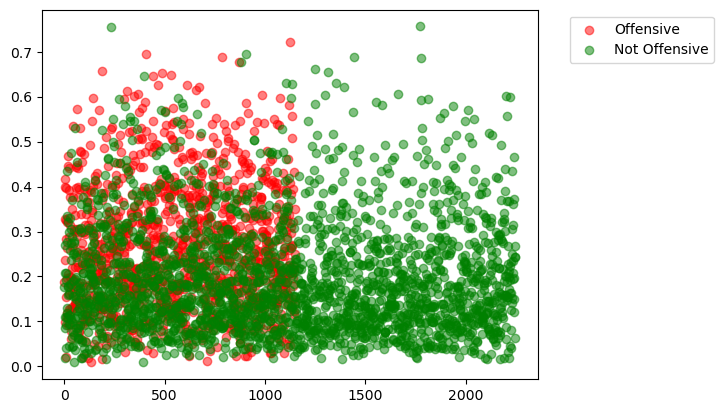

In [10]:
zeros = z[z['offensive'] == 0]
ones = z[z['offensive'] == 1]
from matplotlib import pyplot as plt
plt.scatter(x = list(range(len(ones))), y = ones['values'], color='red', alpha=0.5)
plt.scatter(x = list(range(len(zeros))), y = zeros['values'], color='green', alpha=0.5)
plt.legend(['Offensive', 'Not Offensive'], bbox_to_anchor=(1.05, 1), loc='upper left')

In [26]:
accuracies = []
from sklearn.metrics import f1_score

for threshold in np.linspace(0, 0.6, 1000):
    accuracies += [f1_score(z['offensive'], z['values'] > threshold)]
    

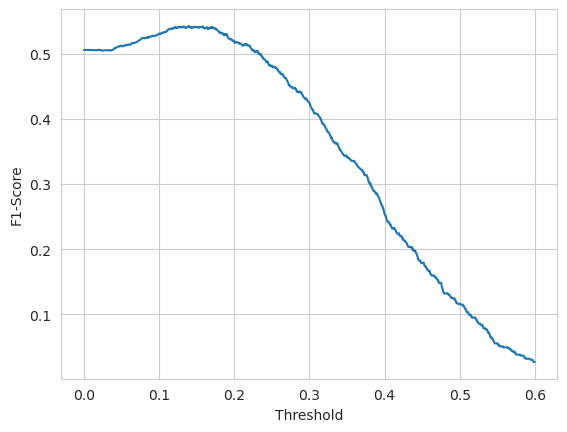

In [37]:
sns.set_style("whitegrid")

plt.ylabel('F1-Score')
plt.xlabel('Threshold')
plt.plot(np.linspace(0, 0.6, 1000), accuracies)

In [ ]:
import csv, time, random
from googletrans import Translator 
from tqdm import tqdm

import os, sys, dotenv

dotenv.load_dotenv()

import pandas as pd

def TranslatePivotLang(dataframe, step=29) -> None:
  
    translations = []
    for i in tqdm(range(0, len(dataframe), step)):

        ts = Translator()
        time.sleep(random.random()*3)
        try:
         translations += (ts.translate(text='\n\n\n'.join(dataframe[i:i + step]['adjective'].to_list()), 
                              src = 'de', 
                              dest = 'en').text).split('\n\n\n')
        except:
          print(f'An exception occurred on index {i}')

    dataframe['adjective_en'] = translations
    return dataframe

df = pd.read_excel('adj.xlsx')
df.rename(columns={'Adjektive ': 'adjective'}, inplace=True)
df = TranslatePivotLang(df, step = 100)

import pandas as pd
import openai, json

client = openai.OpenAI(api_key = os.getenv('OPENAI_API_KEY'))

df = pd.read_csv('translated_adj.csv')

def get_translation( word ): 
  
  for i in range(3):
    try:
      response = client.chat.completions.create(
        model="gpt-4",
        # logprobs = True,
        messages=[
          {"role": "system", "content": "You are a helpful assistant expert in linguistics and give responses in JSON."},
          {"role": "user", "content": f"Translate from german the word '{word}' into a single english word. Give me the response in a dictionary with a key 'translation'"},
        ]
      )
      print('translation retrieved', end = ' ')
      return json.loads(response.choices[0].message.content)['translation']
    except:
      print('translation failed', end = ' ')
  return ' '


df['trans4wordnet'] = [row['adjective_en'] if ' ' not in row['adjective_en'] else get_translation(row['adjective']) for _, row in df.iterrows()]

translation retrieved translation retrieved translation retrieved translation retrieved translation retrieved translation retrieved translation retrieved translation retrieved translation retrieved translation retrieved translation retrieved translation retrieved translation retrieved translation retrieved translation retrieved translation retrieved translation retrieved translation retrieved translation retrieved translation retrieved translation retrieved translation retrieved translation retrieved translation retrieved translation retrieved translation retrieved translation retrieved 

In [4]:
import nltk , pandas as pd
from nltk.corpus import wordnet
nltk.download('wordnet')

def get_wordnet( word ):
  syn = wordnet.synsets( word )
  try:  
    return syn[0].definition()
  except:
    return ' '
  
df = pd.read_csv('translation_corrected.csv')
df['synsets'] = [get_wordnet(row['trans4wordnet']) for _, row in df.iterrows()]
df.to_csv('translation_corrected.csv')


[nltk_data] Downloading package wordnet to /home/rlabadie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
import numpy as np, pandas as pd
import pickle
import seaborn as sns

with open('germeval/probabilities_train_aws.pickle', 'rb') as handle:
    data_transformation = pickle.load(handle)
    mapping_train = {data_transformation['id'][i]:np.array(data_transformation['values'][i]) for i in range(len(data_transformation['id']))}


with open('germeval/probabilities_test.pickle', 'rb') as handle:
    data_transformation = pickle.load(handle)
    mapping_test = {data_transformation['id'][i]:np.array(data_transformation['values'][i]) for i in range(len(data_transformation['id']))}

df_test = pd.read_csv('germeval/germeval_test.csv', sep=',')
df_train = pd.read_csv('germeval/germeval_train.csv', sep=',')

In [7]:

feature_vectors_train = []
labels_train = []
texts_train = []

feature_vectors_test = []
labels_test = []
texts_test = []


for _, row in df_train.iterrows():
    feature_vectors_train += [mapping_train[row['id']]]
    labels_train += [row['Class']]
    # texts_train += [ row['Context'] + row['Text']]
    texts_train += [ row['Text']]


for _, row in df_test.iterrows():
    feature_vectors_test += [mapping_test[row['id']]]
    labels_test += [row['Class']]
    texts_test += [row['Text']]
    # texts_test += [row['Context'] + row['Text']]


feature_vectors_train = np.array(feature_vectors_train)
feature_vectors_test = np.array(feature_vectors_test)

In [ ]:
labels_train = np.array(labels_train)
labels_test = np.array(labels_test)

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, accuracy_score as acc

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm import tqdm

from functools import partial


models = {
    # 'SVM': partial(SVC, kernel='linear', C=1, cache_size=3000),
    # 'Logistic Regression': partial(LogisticRegression),
    # 'Random Forest': partial(RandomForestClassifier, random_state=42),
    # 'Gradient Boosting': partial(GradientBoostingClassifier, random_state=42),
    'MLP': partial(MLPClassifier)#, hidden_layer_sizes=( 24))
}


In [21]:
import random; random.seed(0)

def evaluate(model, X_test, y_test):

    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average='macro')


performance = {}
t_performance = {}

for i in range(5):
	for model_name, model in tqdm(models.items()):

		clf = model()
		clf.fit(feature_vectors_train, labels_train)
		performance[model_name] = [evaluate(clf, feature_vectors_test, labels_test)] if model_name not in performance else performance[model_name] + [evaluate(clf, feature_vectors_test, labels_test)]
    # t_performance[model_name] = evaluate(clf, feature_vectors_train, labels_train)

# from sklearn.decomposition import PCA
# pca = PCA(n_components=500)

# pca.fit(feature_vector_tfidf_test)
# x_transform = pca.transform(feature_vector_tfidf_test)
# x_train_transform = pca.transform(feature_vector_tfidf_train)


# clf = models['SVM']()
# clf.fit(x_train_transform, labels_train)
# performance['tfidf']  = evaluate(clf, x_transform, labels_test)
# t_performance['tfidf']  = evaluate(clf, x_train_transform, labels_train)


  0%|          | 0/1 [00:00<?, ?it/s]/home/rlabadie/env_torch-lastest/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
  0%|          | 0/1 [00:00<?, ?it/s]/home/rlabadie/env_torch-lastest/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
  0%|          | 0/1 [00:00<?, ?it/s]/home/rlabadie/env_torch-lastest/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
  0%|          | 0/1 [00:00<?, ?it/s]/home/rlabadie/env_torch-lastest/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_pe

In [23]:
performance


{'MLP': [0.7422720107205386,
  0.734355388064976,
  0.7310327243628356,
  0.6803082900194256,
  0.732504682838841]}

In [21]:
Counter(datao['values'])

Counter({'no': 3321, 'yes': 154, 'unknown': 57})

In [2]:
import pickle 
with open('inference_zero_test_3_voting.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [8]:
from collections import  Counter
Counter(data['values'])

Counter({'no': 3190, 'yes': 342})

In [1]:
import pickle
from collections import Counter
    
with open('ELF22/inference_zero_test_elf.pickle', 'rb') as handle:
    data = pickle.load(handle)

for i in range(len(data['values'])):
    if data['values'][i] in ['unclear', 'uncertain', 'unknown']:
        data['values'][i] = 'neither'
    if '_' in data['values'][i]:
        data['values'][i] = data['values'][i].replace('_', ' ')
    if data['values'][i] == 'ounter speech':
        data['values'][i] = 'counter speech'

    
Counter(data['values'])

Counter({'yes': 440, 'no': 322})

In [9]:
# for i in range(len(data['values'])):
#     if data['id'][i] == 446:
#         data['values'][i] = 'no'

In [10]:
# mapp = {data['id'][i]:data['values'][i] for i in range(len(data['id']))}
# for i in range(len(data['id'])):
#     if data['id'][i] in list(mapp.keys()) and data['values'][i] == 'unknown':
#         data['values'][i] = mapp[data['id'][i]]
#     if data['values'][i] == 'yes.':
#         data['values'][i] = 'yes'

In [7]:
# for i in range(len(data['id'])):
#     if data['values'][i] == 'unknown':
#         data['values'][i] = 'no'

In [4]:
import pandas as pd 
df_test = pd.read_csv('ELF22/ELF22_Task1_test_uniform.csv')

In [5]:
df_test

,Title,Context,Text,Class,text,id
0,Planning on leaving an envelope with some cash...,With a note that it's for them. Is that the be...,Why the hell would you give em money? They get...,2,Planning on leaving an envelope with some cash...,0
1,Tips on arm hypertrophy?,I’m 21M 5’7” 145lbs and I have skinny arms. Or...,The simplest was to get bigger arms fast is hi...,1,Tips on arm hypertrophy? I’m 21M 5’7” 145lbs a...,1
2,Tip for everyone who is trying to shift:,Do not shift when you’re in a bad/sad mood. I’...,Another tip: you can’t fucking shift realities,1,Tip for everyone who is trying to shift: Do no...,2
3,My boyfriend made me turn around to look at my...,How would you guys react in this situation?,"i don’t think he went about it the right way, ...",2,My boyfriend made me turn around to look at my...,3
4,"Second pregnancy. When breast feeding, I go fr...","I'm specifically looking for ""sexy lingerie"" s...",That’s what the calculator said? Holy shit. Th...,2,"Second pregnancy. When breast feeding, I go fr...",4
...,...,...,...,...,...,...
757,Why do oilfield companies prefer to only hire ...,I've read a me people complaining about this i...,Young people know how to turn on a computer. A...,1,Why do oilfield companies prefer to only hire ...,757
758,I can’t stand when people who have a bunch of ...,all i can think is who’s fault is that?? you w...,"Ok but hear me out: everybody, including peopl...",2,I can’t stand when people who have a bunch of ...,758
759,Told my mom im bi :/,She laughed and said no you're not. Later i t...,And you think it is not? Your mother is right....,1,Told my mom im bi :/ She laughed and said no y...,759
760,Facebook University Assessment Difficulty,Does anyone know how hard the FB university co...,"Array/matrix. Dp, sliding window graph, contig...",2,Facebook University Assessment Difficulty Does...,760


In [13]:
g = []
p = []

inner_mapping = {'yes': 2, 'no': 1}
mapping_test = {data['id'][i]:inner_mapping[data['values'][i]] for i in range(len(data['id']))}

In [14]:
Counter(mapping_test.values())

Counter({2: 440, 1: 322})

In [15]:
from collections import Counter
Counter(df_test['Class'])

Counter({2: 422, 1: 340})

In [16]:
for _, row in df_test.iterrows():
    g += [row['Class'] ]
    p += [mapping_test[row['id']]]

from sklearn.metrics import f1_score, classification_report, accuracy_score as acc
f1_score(g, p, average='macro')

0.40711196472757094

In [10]:
df_test

,index,text,offensive,1_category
0,0,"Meine Mutter hat mir erzählt, dass mein Vater ...",0,0
1,1,@Tom174_ @davidbest95 Meine Reaktion; |LBR| Ni...,0,0
2,2,"#Merkel rollt dem Emir von #Katar, der islamis...",0,0
3,3,„Merle ist kein junges unschuldiges Mädchen“ K...,0,0
4,4,@umweltundaktiv Asylantenflut bringt eben nur ...,1,ABUSE
...,...,...,...,...
3527,3527,"@schlabonski tja, es können einen nicht alle L...",0,0
3528,3528,"@RKnillmann @lawyerberlin @AfD Aha, der Islam ...",1,ABUSE
3529,3529,"@podilein Mannheim, weltoffen und kunterbunt. ...",1,ABUSE
3530,3530,@stephanweil was ist nun mit kostenlosen Kitas...,0,0


## Cross-validation setting

In [3]:
import numpy as np, pandas as pd
import pickle
import seaborn as sns

# with open('Thou_Shalt_Not_Hate/TSNH_uniform_probabilities_train.pickle', 'rb') as handle:
#     data_transformation = pickle.load(handle)
#     mapping = {data_transformation['id'][i]:np.array(data_transformation['values'][i]) for i in range(len(data_transformation['id']))}

df = pd.read_csv('Thou_Shalt_Not_Hate/TSNH_uniform.csv', sep=',').fillna('-1')

In [4]:

feature_vectors = []
labels = []
texts = []
ids = []

for _, row in df.iterrows():

    # if row['id'] not in mapping:
    #     continue
    # feature_vectors += [mapping[row['id']]]
    labels += [int(row['Class'] == 'counterspeech')]
    texts += [ row['Text']]
    ids += [row['id']]

# feature_vectors = np.array(feature_vectors)
texts = np.array(texts)
labels = np.array(labels)
ids = np.array(ids)

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, accuracy_score as acc

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm import tqdm

from functools import partial


# models_prob = {
#     'SVM': partial(SVC, kernel='linear', C=1, random_state=42, cache_size=3000),
#     'Logistic Regression': partial(LogisticRegression, random_state=42),
#     'Random Forest': partial(RandomForestClassifier, random_state=42),
#     'Gradient Boosting': partial(GradientBoostingClassifier, random_state=42),
#     'MLP': partial(MLPClassifier, random_state=42)#, hidden_layer_sizes=( 24))
# }

models_raw  = {
    'Logistic Regression': partial(LogisticRegression),
    'SVM': partial(SVC, kernel='linear', C=1),
    'Random Forest': partial(RandomForestClassifier),
    'Gradient Boosting': partial(GradientBoostingClassifier),
    'MLP': partial(MLPClassifier)
}



In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from tqdm import tqdm


def evaluate(model, X_test, y_test):

    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average='macro')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


data_train = {'x': vectorizer.transform(texts).toarray(), 'y': labels}

performance = {}
# t_performance = {}
# test_split_indices = {}
for i, (train_index, test_index) in enumerate(skf.split(texts, labels)):

    # X_train, X_test = feature_vectors[train_index], feature_vectors[test_index]
    X_text_train, X_text_test = data_train['x'][train_index], data_train['x'][test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    

    for model_name, model in tqdm(models_raw.items()):
        if model_name not in performance: 
            performance[model_name] = []
            # t_performance[model_name] = []

        clf = model()
        clf.fit(X_text_train, y_train)
        performance[model_name] += [evaluate(clf, X_text_test, y_test)]
        # t_performance[model_name] += [evaluate(clf, X_train, y_train)]

    # if 'tfidf' not in performance: 
    #     performance['tfidf'] = []
    #     t_performance['tfidf'] = []
    

    # vectorizer = TfidfVectorizer(ngram_range = (3, 3), analyzer='char').fit(X_text_train)

    # feature_vector_tfidf_train = vectorizer.transform(X_text_train).toarray()
    # feature_vector_tfidf_test = vectorizer.transform(X_text_test).toarray()

    # pca = PCA(n_components=500)

    # pca.fit(feature_vector_tfidf_train)
    # x_test_transform = pca.transform(feature_vector_tfidf_test)
    # x_train_transform = pca.transform(feature_vector_tfidf_train)

    # # clf = models_prob['SVM']()
    # # clf.fit(x_train_transform, y_train)
    # # performance['tfidf'] += [evaluate(clf, x_test_transform, y_test)]
    # # t_performance['tfidf'] += [evaluate(clf, x_train_transform, y_train)]

    # for model_name, model in tqdm(models_raw.items()):
    #     if 'raw' + model_name not in performance: 
    #         performance['raw' + model_name] = []
    #         t_performance['raw' + model_name] = []

    #     if model_name == 'SVM':
    #         clf = model(max_iter = 500)
    #     else: clf = model()
    #     clf.fit(feature_vector_tfidf_train, y_train)
    #     performance['raw' + model_name] += [evaluate(clf, feature_vector_tfidf_test, y_test)]
    #     t_performance['raw' + model_name] += [evaluate(clf, feature_vector_tfidf_train, y_train)]

 80%|████████  | 4/5 [40:29<09:36, 576.84s/it] /home/rlabadie/env_torch-lastest/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
100%|██████████| 5/5 [56:13<00:00, 674.68s/it] 


In [9]:
for i in performance:
    print(i, np.mean(performance[i]), performance[i])

Logistic Regression 0.6932806525406312 [0.6879440772020138, 0.6950694141647995, 0.6823788468961645, 0.700584365256625, 0.7004265591835528]
SVM 0.695768816236529 [0.6926181737912368, 0.7051260177023563, 0.6848881330907681, 0.697319877715644, 0.6988918788826397]
Random Forest 0.6885615732034752 [0.689034000596194, 0.692278643545174, 0.6797127055639445, 0.6956954952106569, 0.6860870211014063]
Gradient Boosting 0.667679992208193 [0.6707738735594921, 0.6652446524216553, 0.6541364741908042, 0.6761423298622726, 0.6721026310067406]
MLP 0.6711990397463279 [0.6710930747316719, 0.6738212947570563, 0.6585135627698187, 0.6741168907782424, 0.6784503756948499]


In [40]:
texts[np.array([1, 23])]

array(['AMEN PASTOR!!!!!!!!', 'Those Police are Racists'], dtype='<U10000')

In [13]:
from collections import Counter
df = df[df['Class'] != '-1']
Counter(df['Class'].to_list())

Counter({'noncounter': 7024, 'counterspeech': 6898})

In [20]:
f1_score(df['Class'].to_list(), [random.choice(['counterspeech', 'noncounter']) for i in range(len(df))], average='macro')

0.5032829008571696